# UNSEEN analysis


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import stability
from unseen import eva
from unseen import general_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
metric = "growing-season-pr"
var = "pr"
metric_plot_label = "total AMJJASO rainfall (mm)"
metric_plot_upper_limit = 1000
obs_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_AGCD-CSIRO_1901-2024_AMJJASO_crops-SA.nc"
model_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA.nc"
model_add_bc_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-additive.nc"
model_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_add_bc_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/similarity-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-additive.nc"
similarity_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/similarity-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_raw_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/similarity-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_AGCD-CSIRO.nc"
independence_plot = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/independence-test_growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA.png"
stability_plot_empirical = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/stability-test-empirical_growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA.png"
stability_plot_gev = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/stability-test-gev_growing-season-pr_CAFE-c5-d60-pX-f6_19951101-20201101_AMJJASO_crops-SA.png"
moments_add_plot = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/moments-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-additive.png"
moments_mulc_plot = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/moments-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_bias-corrected-AGCD-CSIRO-multiplicative.png"
moments_raw_plot = "/g/data/xv83/unseen-projects/outputs/wheatbelt/figures/moments-test_growing-season-pr_CAFE-c5-d60-pX-f6_1995-2020_AMJJASO_crops-SA_AGCD-CSIRO.png"
model_name = "CAFE"
min_lead = 0
region_name = "crops-SA"
shape_file = "/g/data/xv83/unseen-projects/outputs/wheatbelt/shapefiles/crops_SA.shp"
shape_overlap = 0.01
file_list = (
    "/g/data/xv83/unseen-projects/code/file_lists/CAFE_c5-d60-pX-f6_pr_files.txt"
)


In [4]:
# Required parameters
assert 'metric' in locals(), "Must provide a metric name"
assert 'var' in locals(), "Must provide a variable name"
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert 'shape_overlap' in locals(), "Must provide a shape overlap fraction"
assert 'metric_plot_label' in locals(), "Must provide a plot axis label for the metric"
assert 'metric_plot_upper_limit' in locals(), "Must provide an upper limit for the metric value"
assert os.path.isfile(obs_file), "Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"
assert os.path.isfile(stability_plot_empirical), "Must provide an empirical stability test plot (papermill option -p stability_plot_empirical [filepath])"
assert os.path.isfile(stability_plot_gev), "Must provide a GEV stability test plot (papermill option -p stability_plot_gev [filepath])"
assert os.path.isfile(moments_add_plot), "Must provide a moments test plot for the additive bias corrected data (papermill option -p moments_add_plot [filepath])"
assert os.path.isfile(moments_mulc_plot), "Must provide a moments test plot for the multiplicative bias corrected data (papermill option -p moments_mulc_plot [filepath])"
assert os.path.isfile(moments_raw_plot), "Must provide a moments test plot for the raw data (papermill option -p moments_raw_plot [filepath])"


In [5]:
units_dict = {
    'pr': 'mm day-1'
}

## Observations

In [6]:
obs_ds = fileio.open_dataset(obs_file)
obs_ds = obs_ds.dropna('time')

In [7]:
years = obs_ds['time'].dt.year.values
obs_df = pd.DataFrame(index=years)
obs_df[var] = obs_ds[var].values

In [8]:
obs_max_event = obs_ds['pr'].values.max()
print(obs_max_event)

466.67133


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/g/data/xv83/unseen-projects/code/dataset_config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=[var],
    lat_bnds=[-44, -10],
    lon_bnds=[113, 155],
    shapefile=shape_file,
    shape_overlap=shape_overlap,
    units={var: units_dict[var]},
    isel=isel_dict,
)

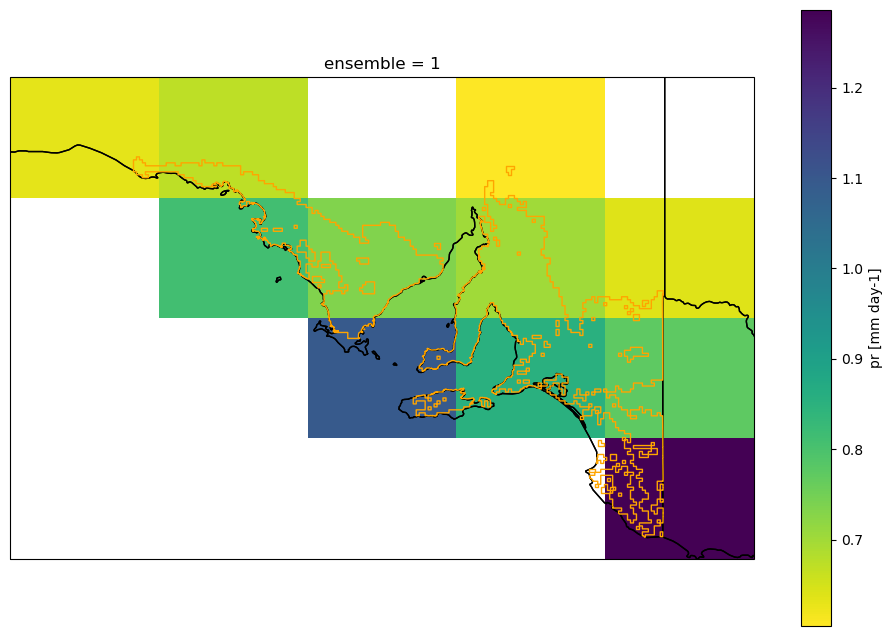

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds[var].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:    (init_date: 26, lead_time: 10, ensemble: 96)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) object 1996-12-31 00:00:00 ... 2021-12-31 00:00:00
    time       (lead_time, init_date) object dask.array<chunksize=(10, 26), meta=np.ndarray>
Data variables:
    pr         (init_date, lead_time, ensemble) float64 dask.array<chunksize=(26, 10, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2
    history:    Wed Mar 27 19:45:59 2024: /g/data/xv83/dbi599/miniconda3/envs...

### Independence testing

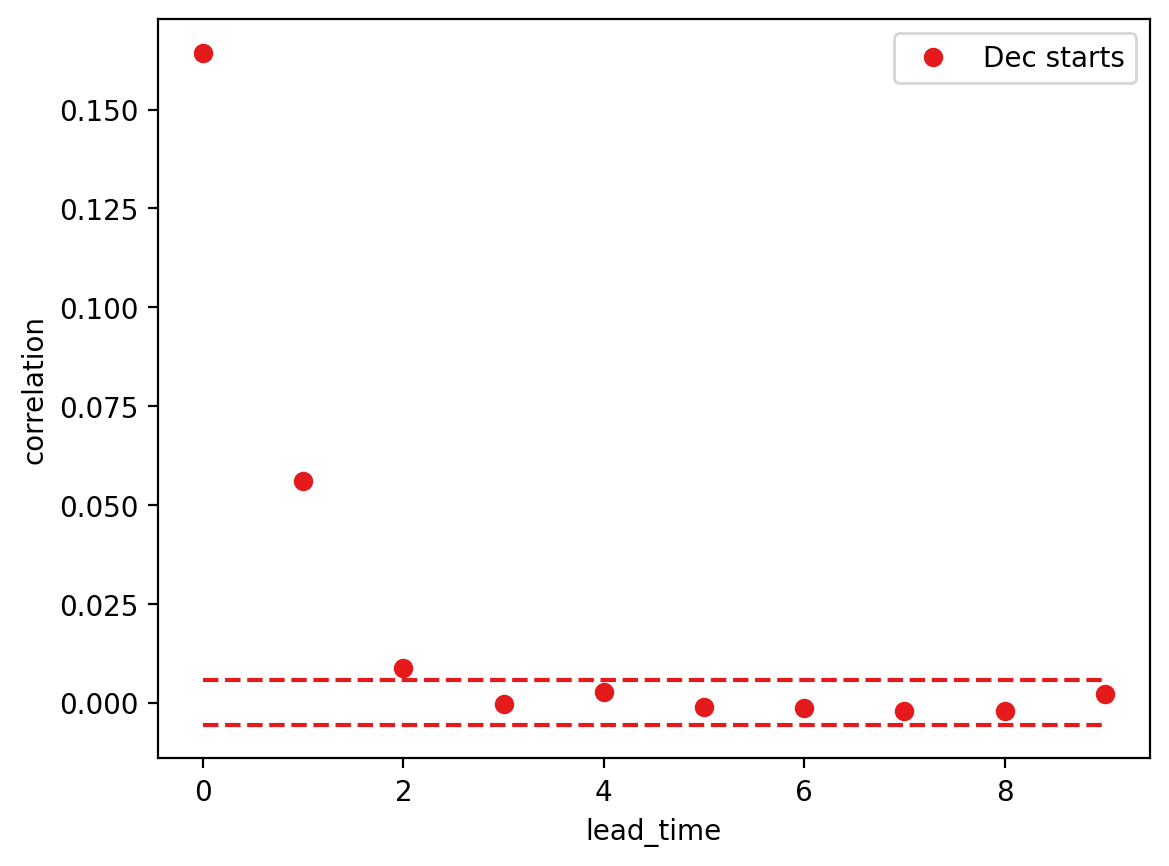

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

0


In [19]:
model_da = model_ds[var].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(24960,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(24960,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(24960,)

### Stability testing

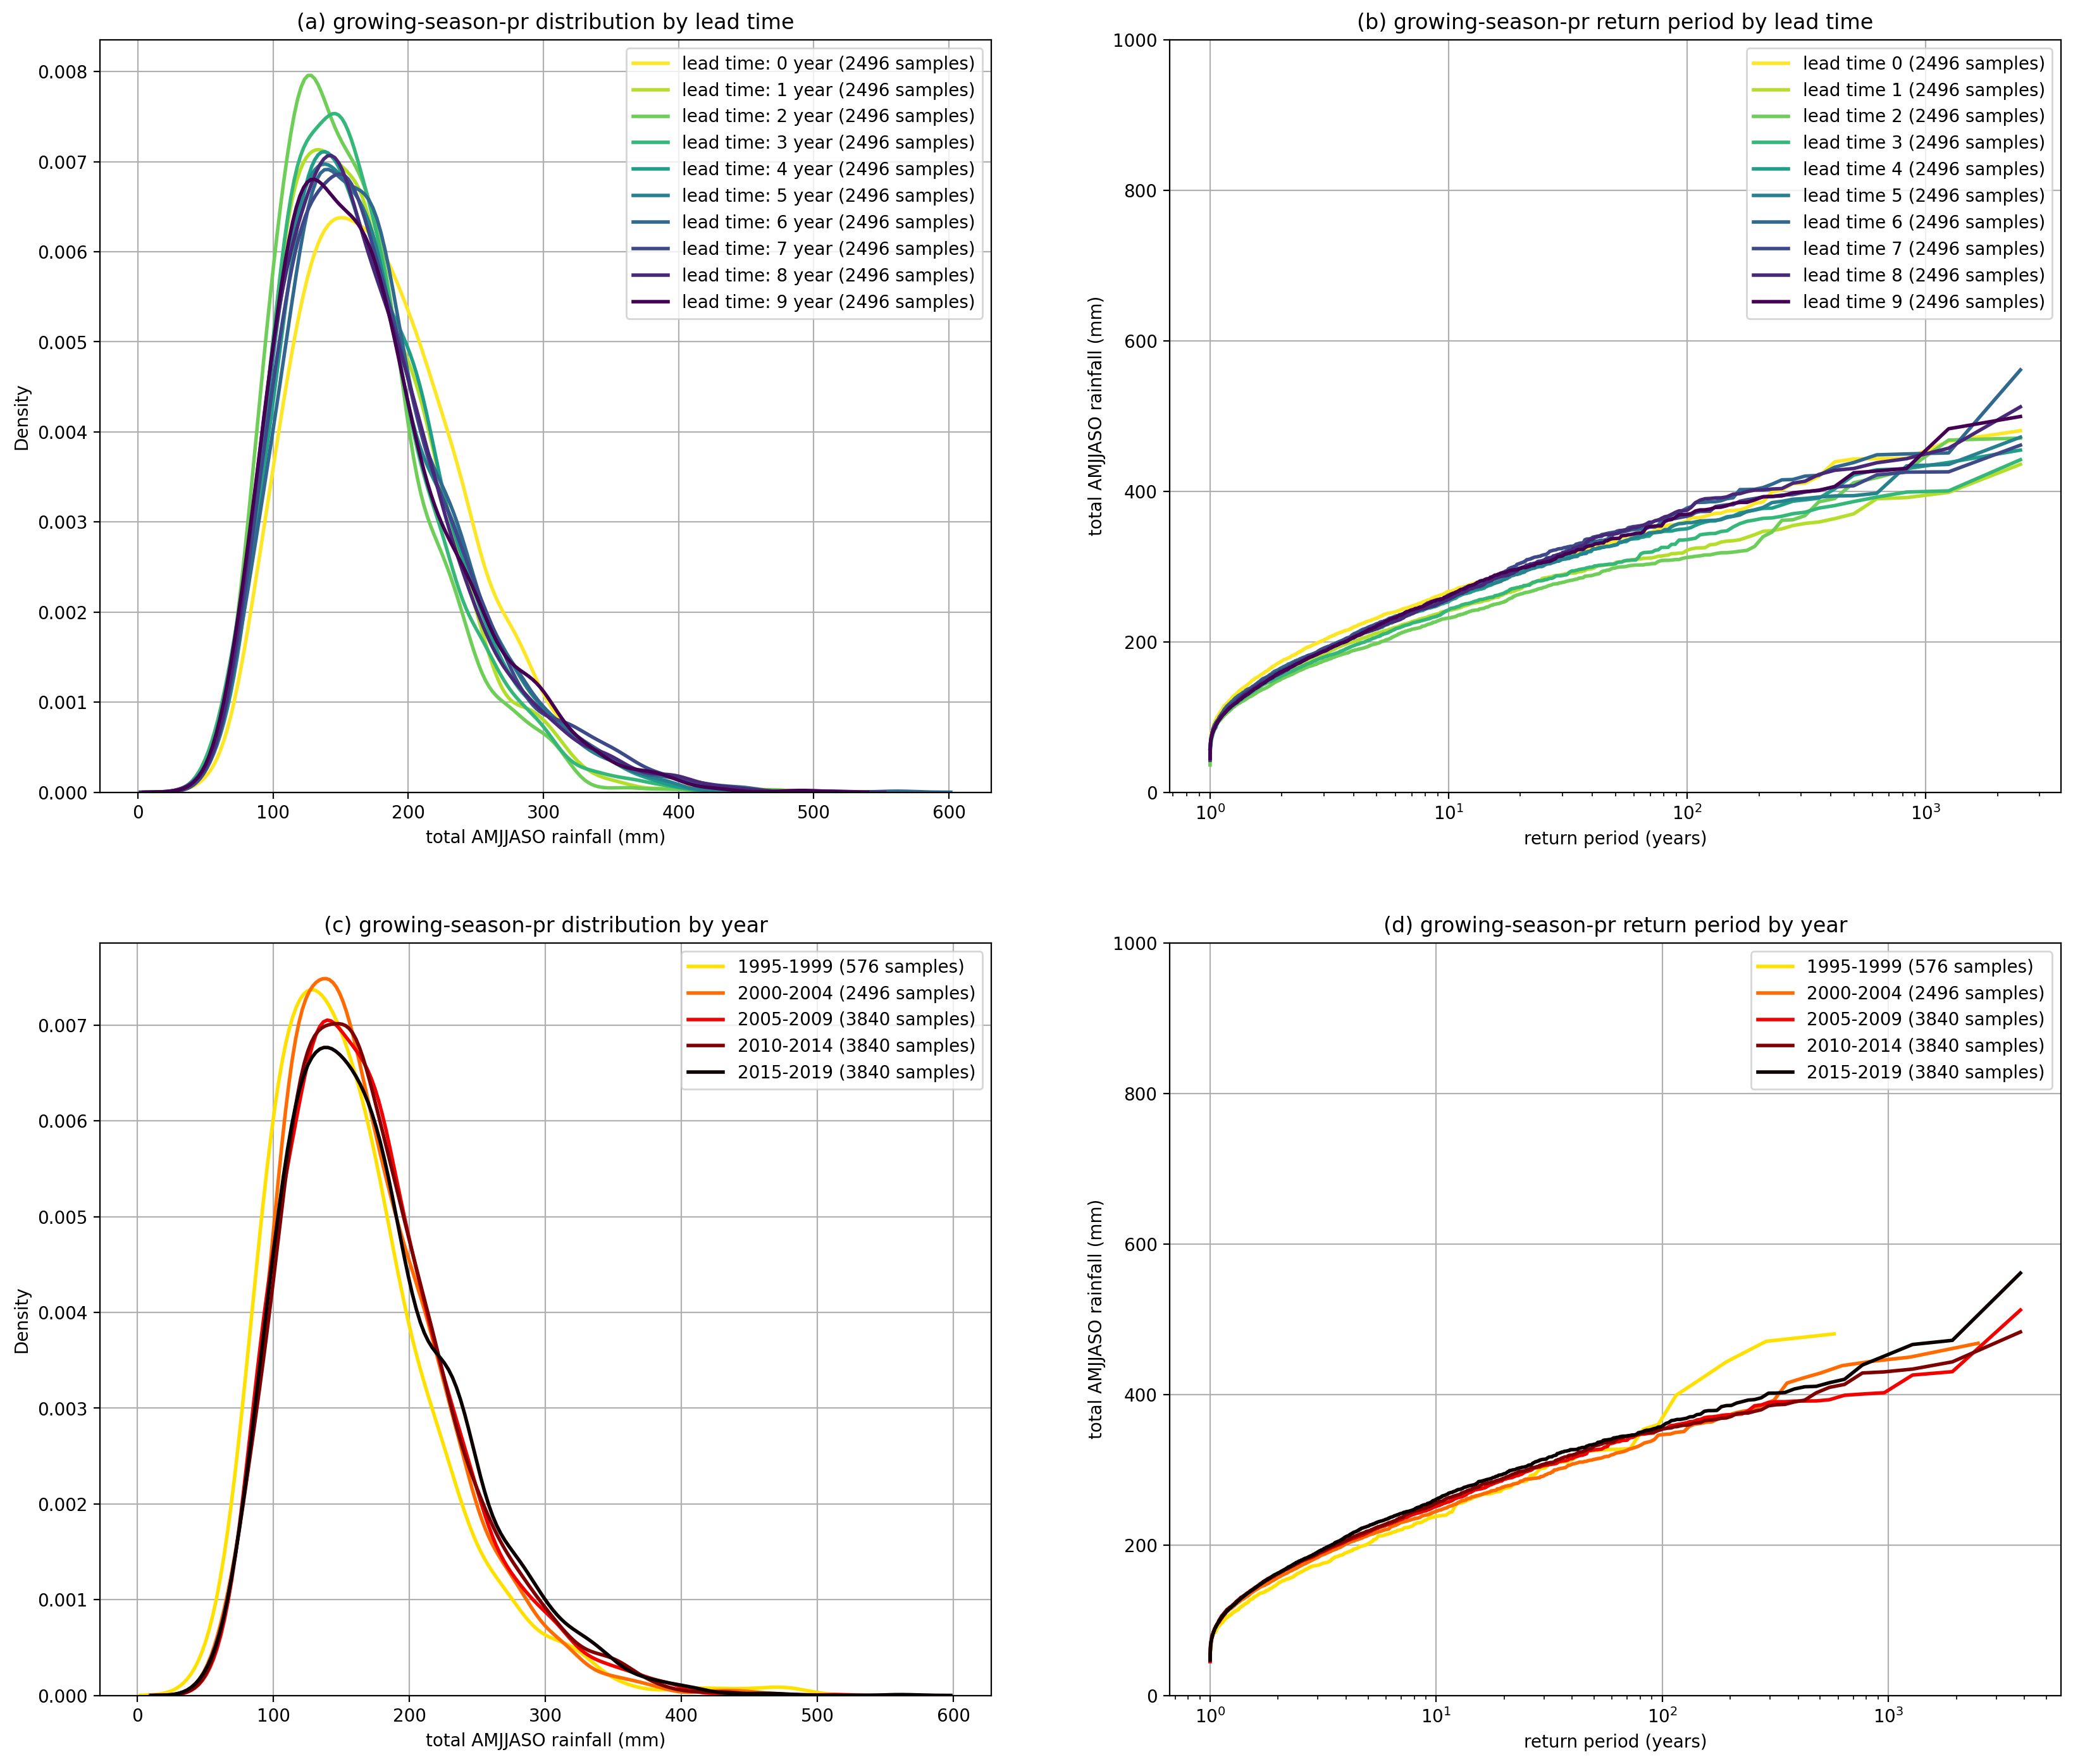

In [26]:
Image(filename=stability_plot_empirical)

### Bias correction and similarity testing

In [27]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, metric_plot_upper_limit)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
#    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
#    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds[var].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
#        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
#        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds[var].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
#    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
#    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    obs_ds[var].plot.hist(
        bins=50, density=True, label='observations', facecolor='tab:gray', alpha=0.7
    )
#    obs_gev_shape, obs_gev_loc, obs_gev_scale = eva.fit_gev(obs_ds[var].values)
#    obs_gev_pdf = gev.pdf(gev_xvals, obs_gev_shape, obs_gev_loc, obs_gev_scale)
#    plt.plot(gev_xvals, obs_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel(metric_plot_label)
    plt.ylabel('probability')
    plt.title(f'{metric} for {region_name} ({model_name})')
    plt.xlim(0, metric_plot_upper_limit)
    plt.legend()
    #if not include_additive:
    #    outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_histogram_{model_name}_{region_name}.png'
    #    print(outfile)
    #    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

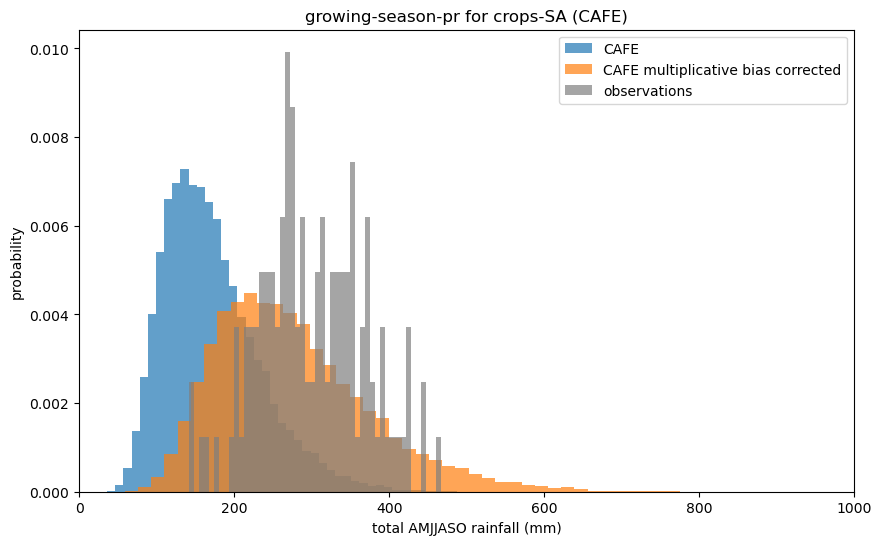

In [28]:
plot_distributions()

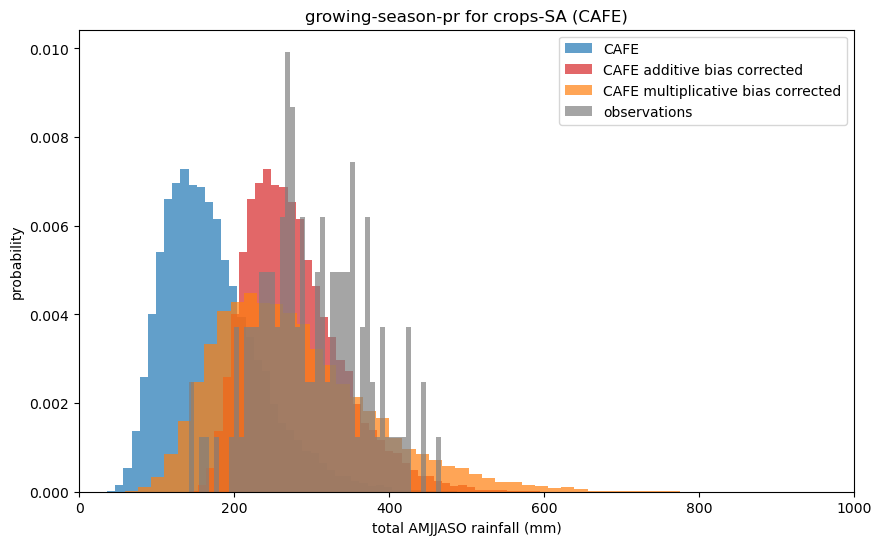

In [29]:
plot_distributions(include_additive=True)

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [30]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [36]:
similarity_raw_ds['ks_statistic'].values

array(0.7539263, dtype=float32)

In [37]:
similarity_raw_ds['ks_pval'].values

array(7.6576384e-16, dtype=float32)

In [38]:
similarity_raw_ds['ad_statistic'].values

array(45.28121, dtype=float32)

In [39]:
similarity_raw_ds['ad_pval'].values

array(0.001, dtype=float32)

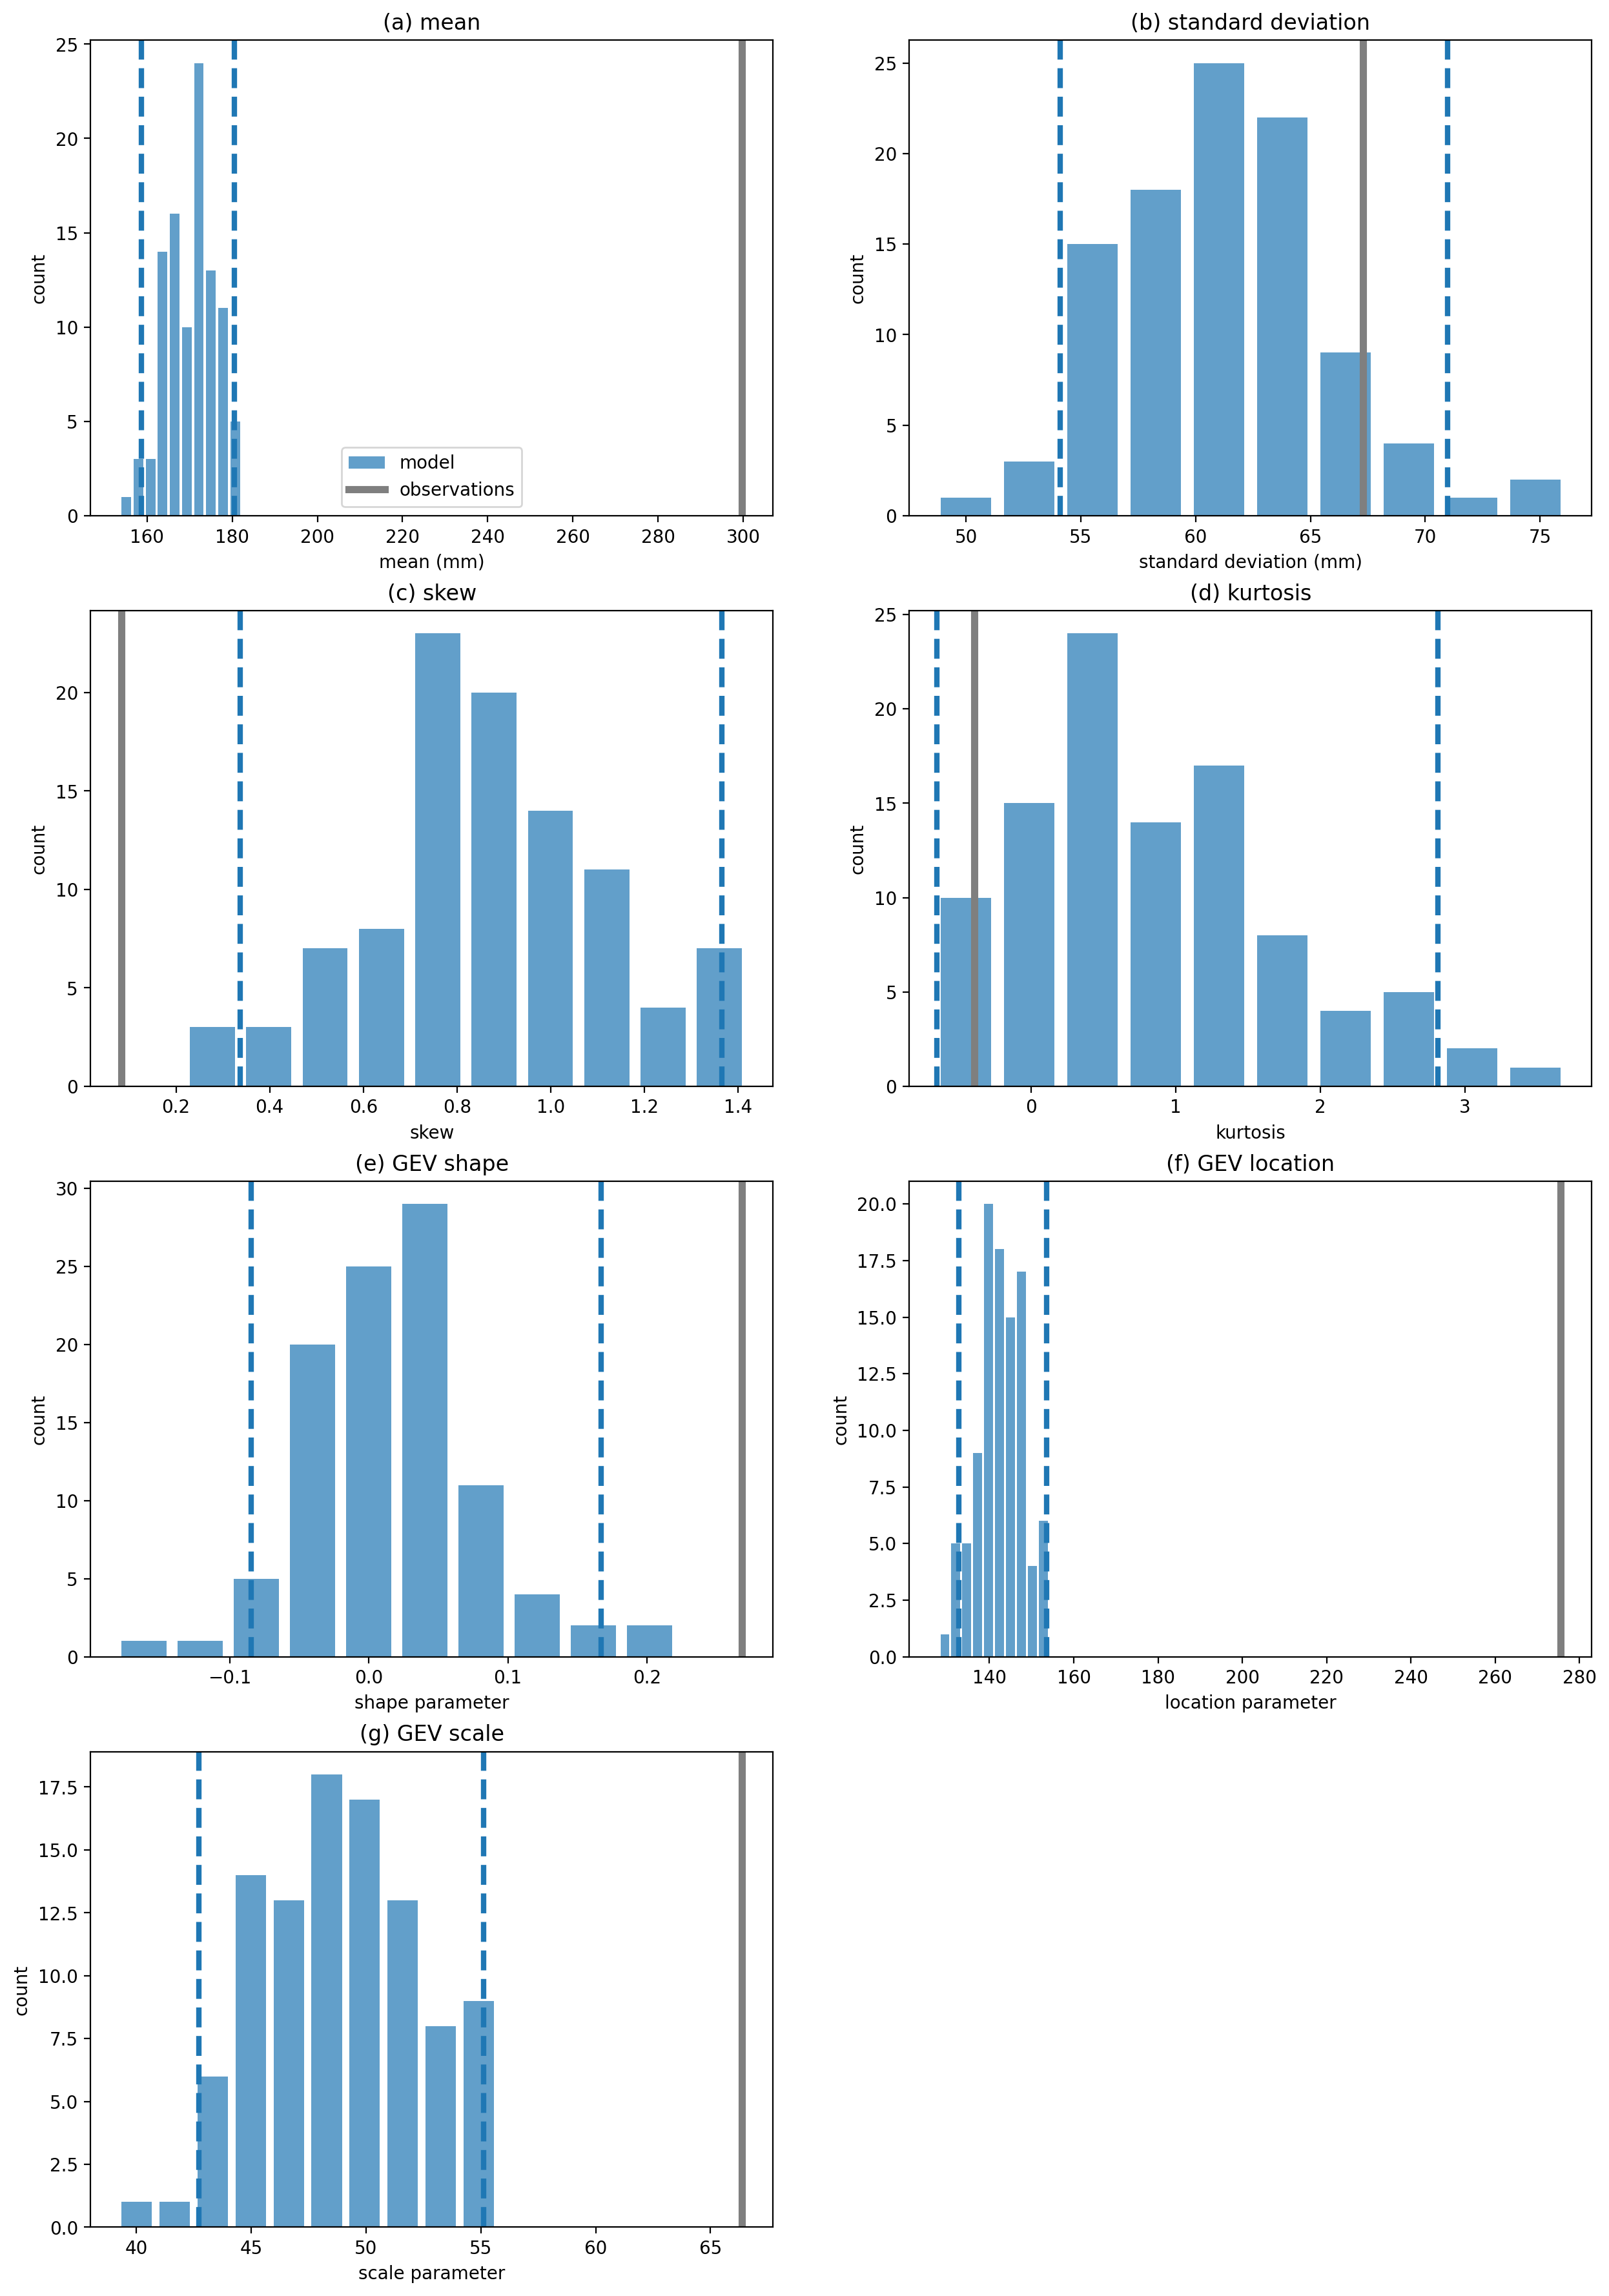

In [40]:
Image(filename=moments_raw_plot)

In [41]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [42]:
similarity_add_bias_ds['ks_statistic'].values

array(0.18353365, dtype=float32)

In [43]:
similarity_add_bias_ds['ks_pval'].values

array(0.306434, dtype=float32)

In [44]:
similarity_add_bias_ds['ad_statistic'].values

array(-0.00570129, dtype=float32)

In [45]:
similarity_add_bias_ds['ad_pval'].values

array(0.25, dtype=float32)

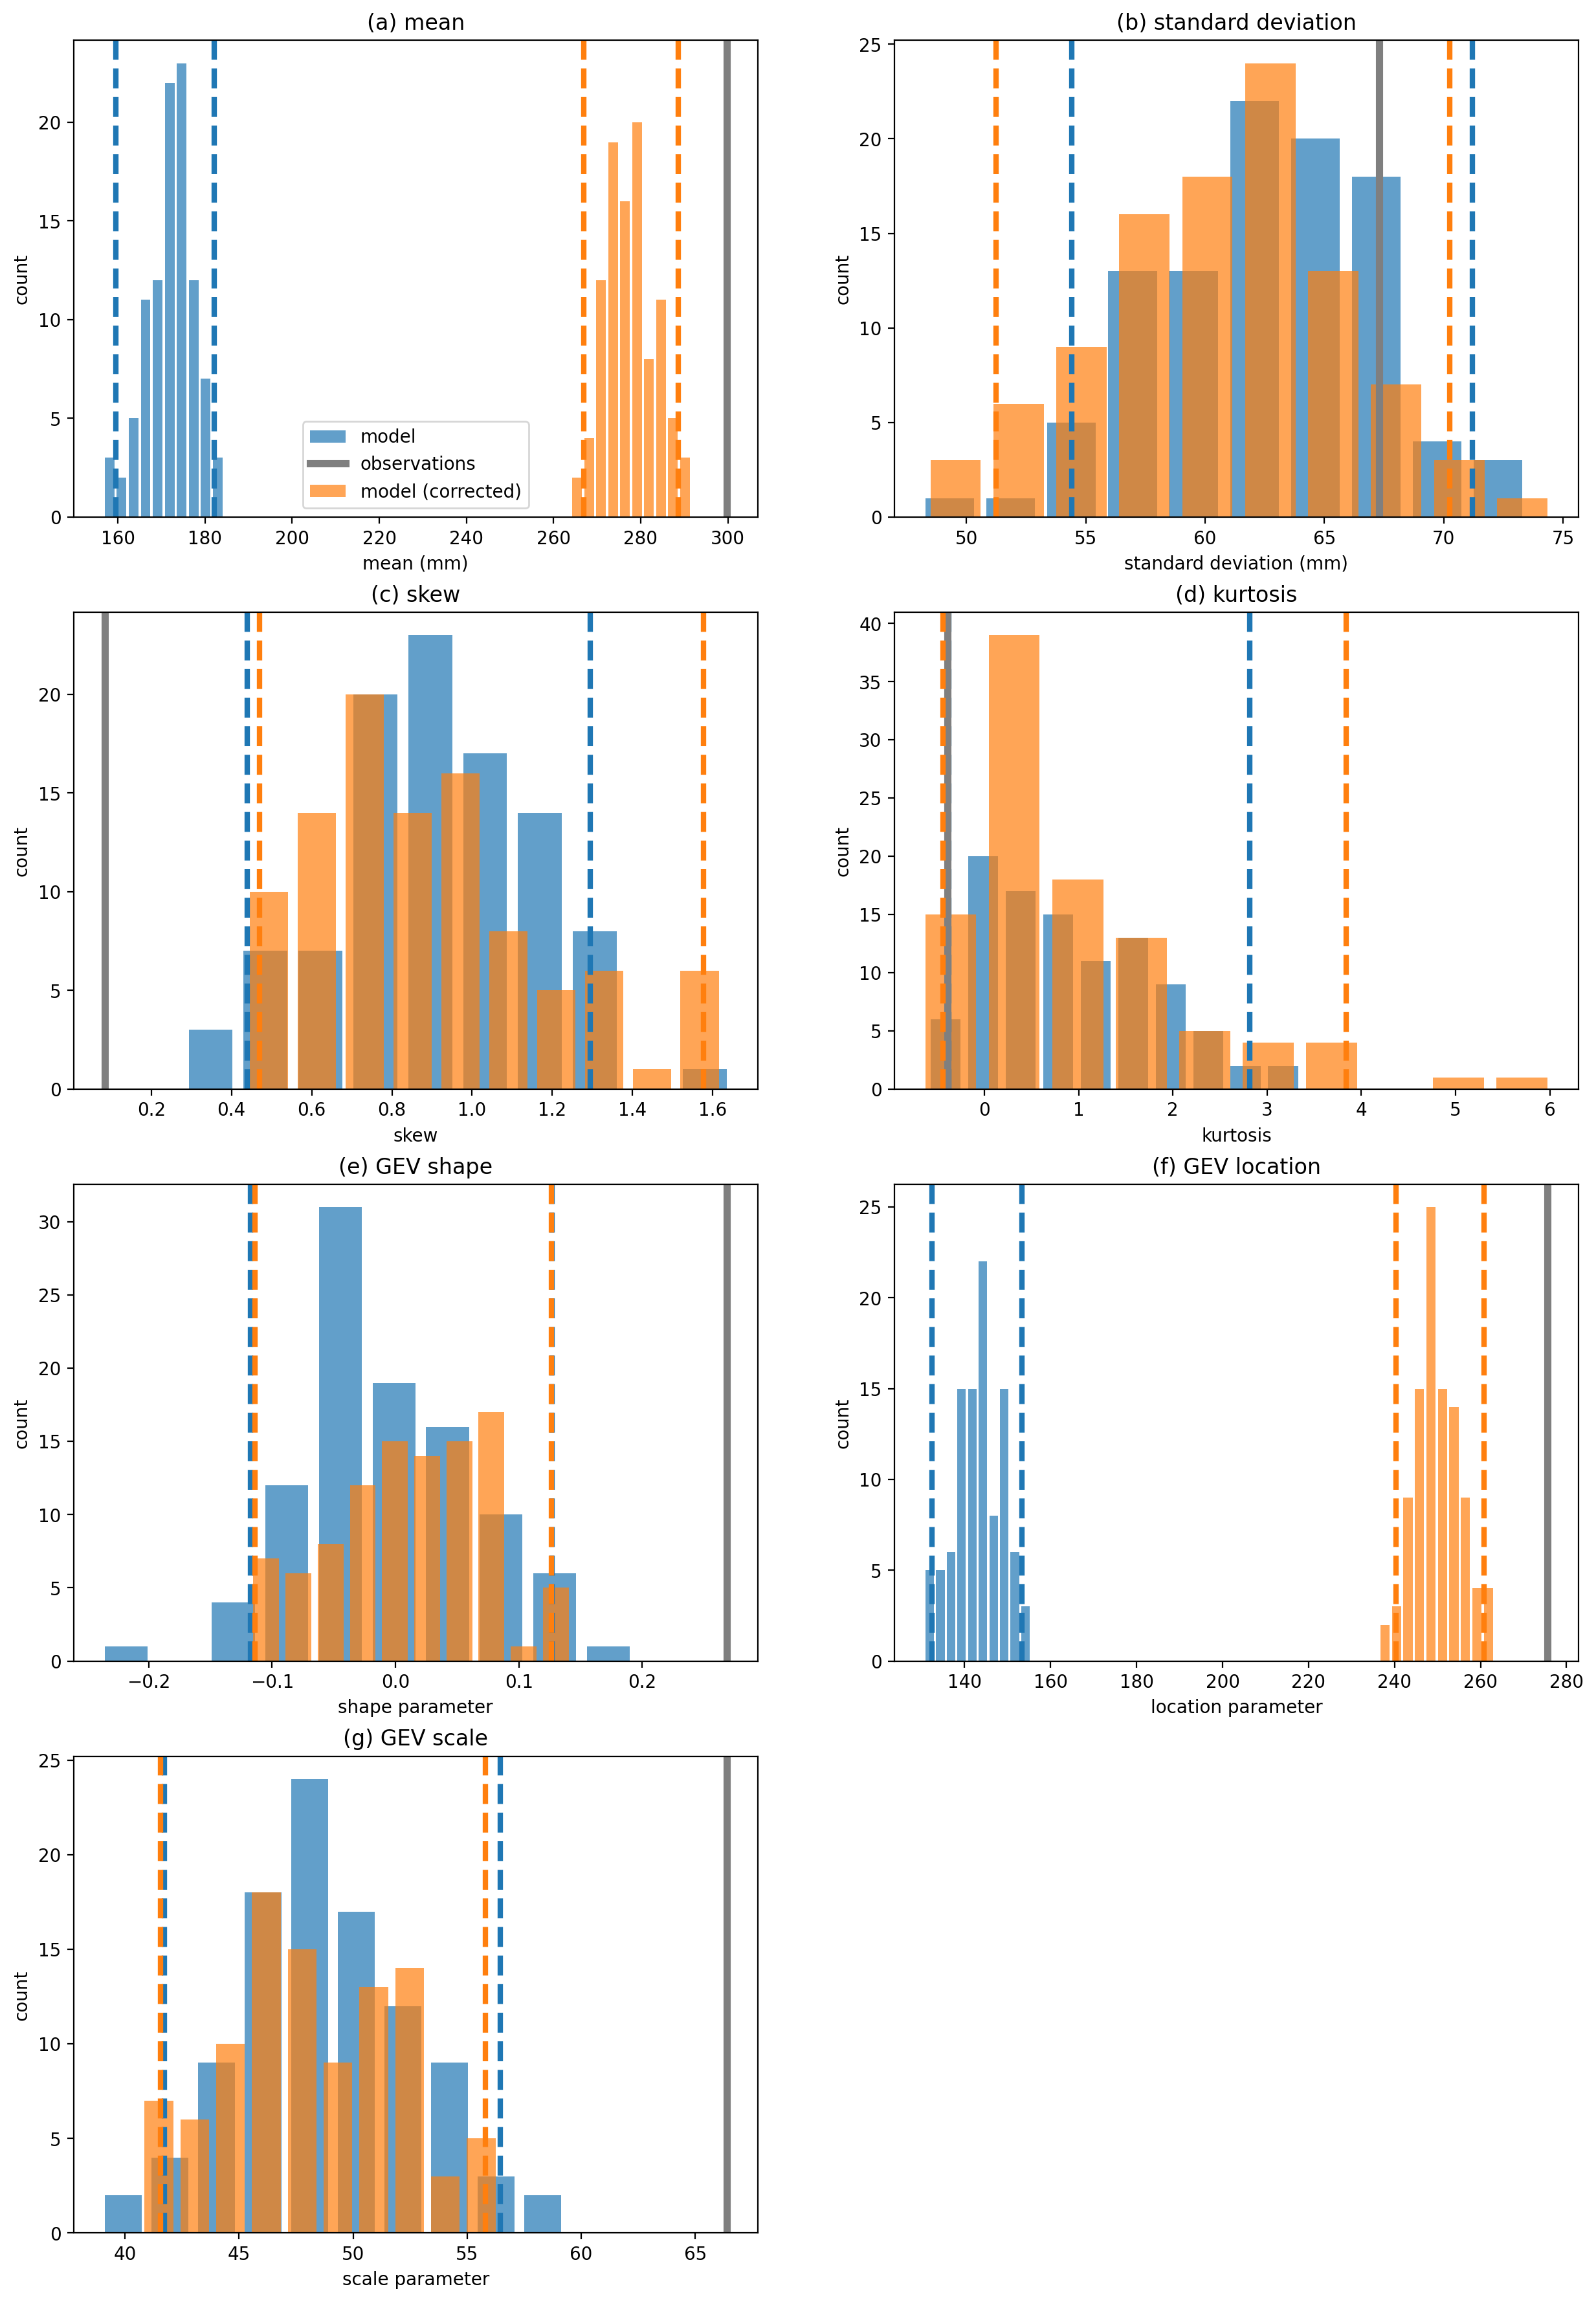

In [46]:
Image(filename=moments_add_plot)

In [47]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [48]:
similarity_mulc_bias_ds['ks_statistic'].values

array(0.267508, dtype=float32)

In [49]:
similarity_mulc_bias_ds['ks_pval'].values

array(0.03924165, dtype=float32)

In [50]:
similarity_mulc_bias_ds['ad_statistic'].values

array(1.7535487, dtype=float32)

In [51]:
similarity_mulc_bias_ds['ad_pval'].values

array(0.06143431, dtype=float32)

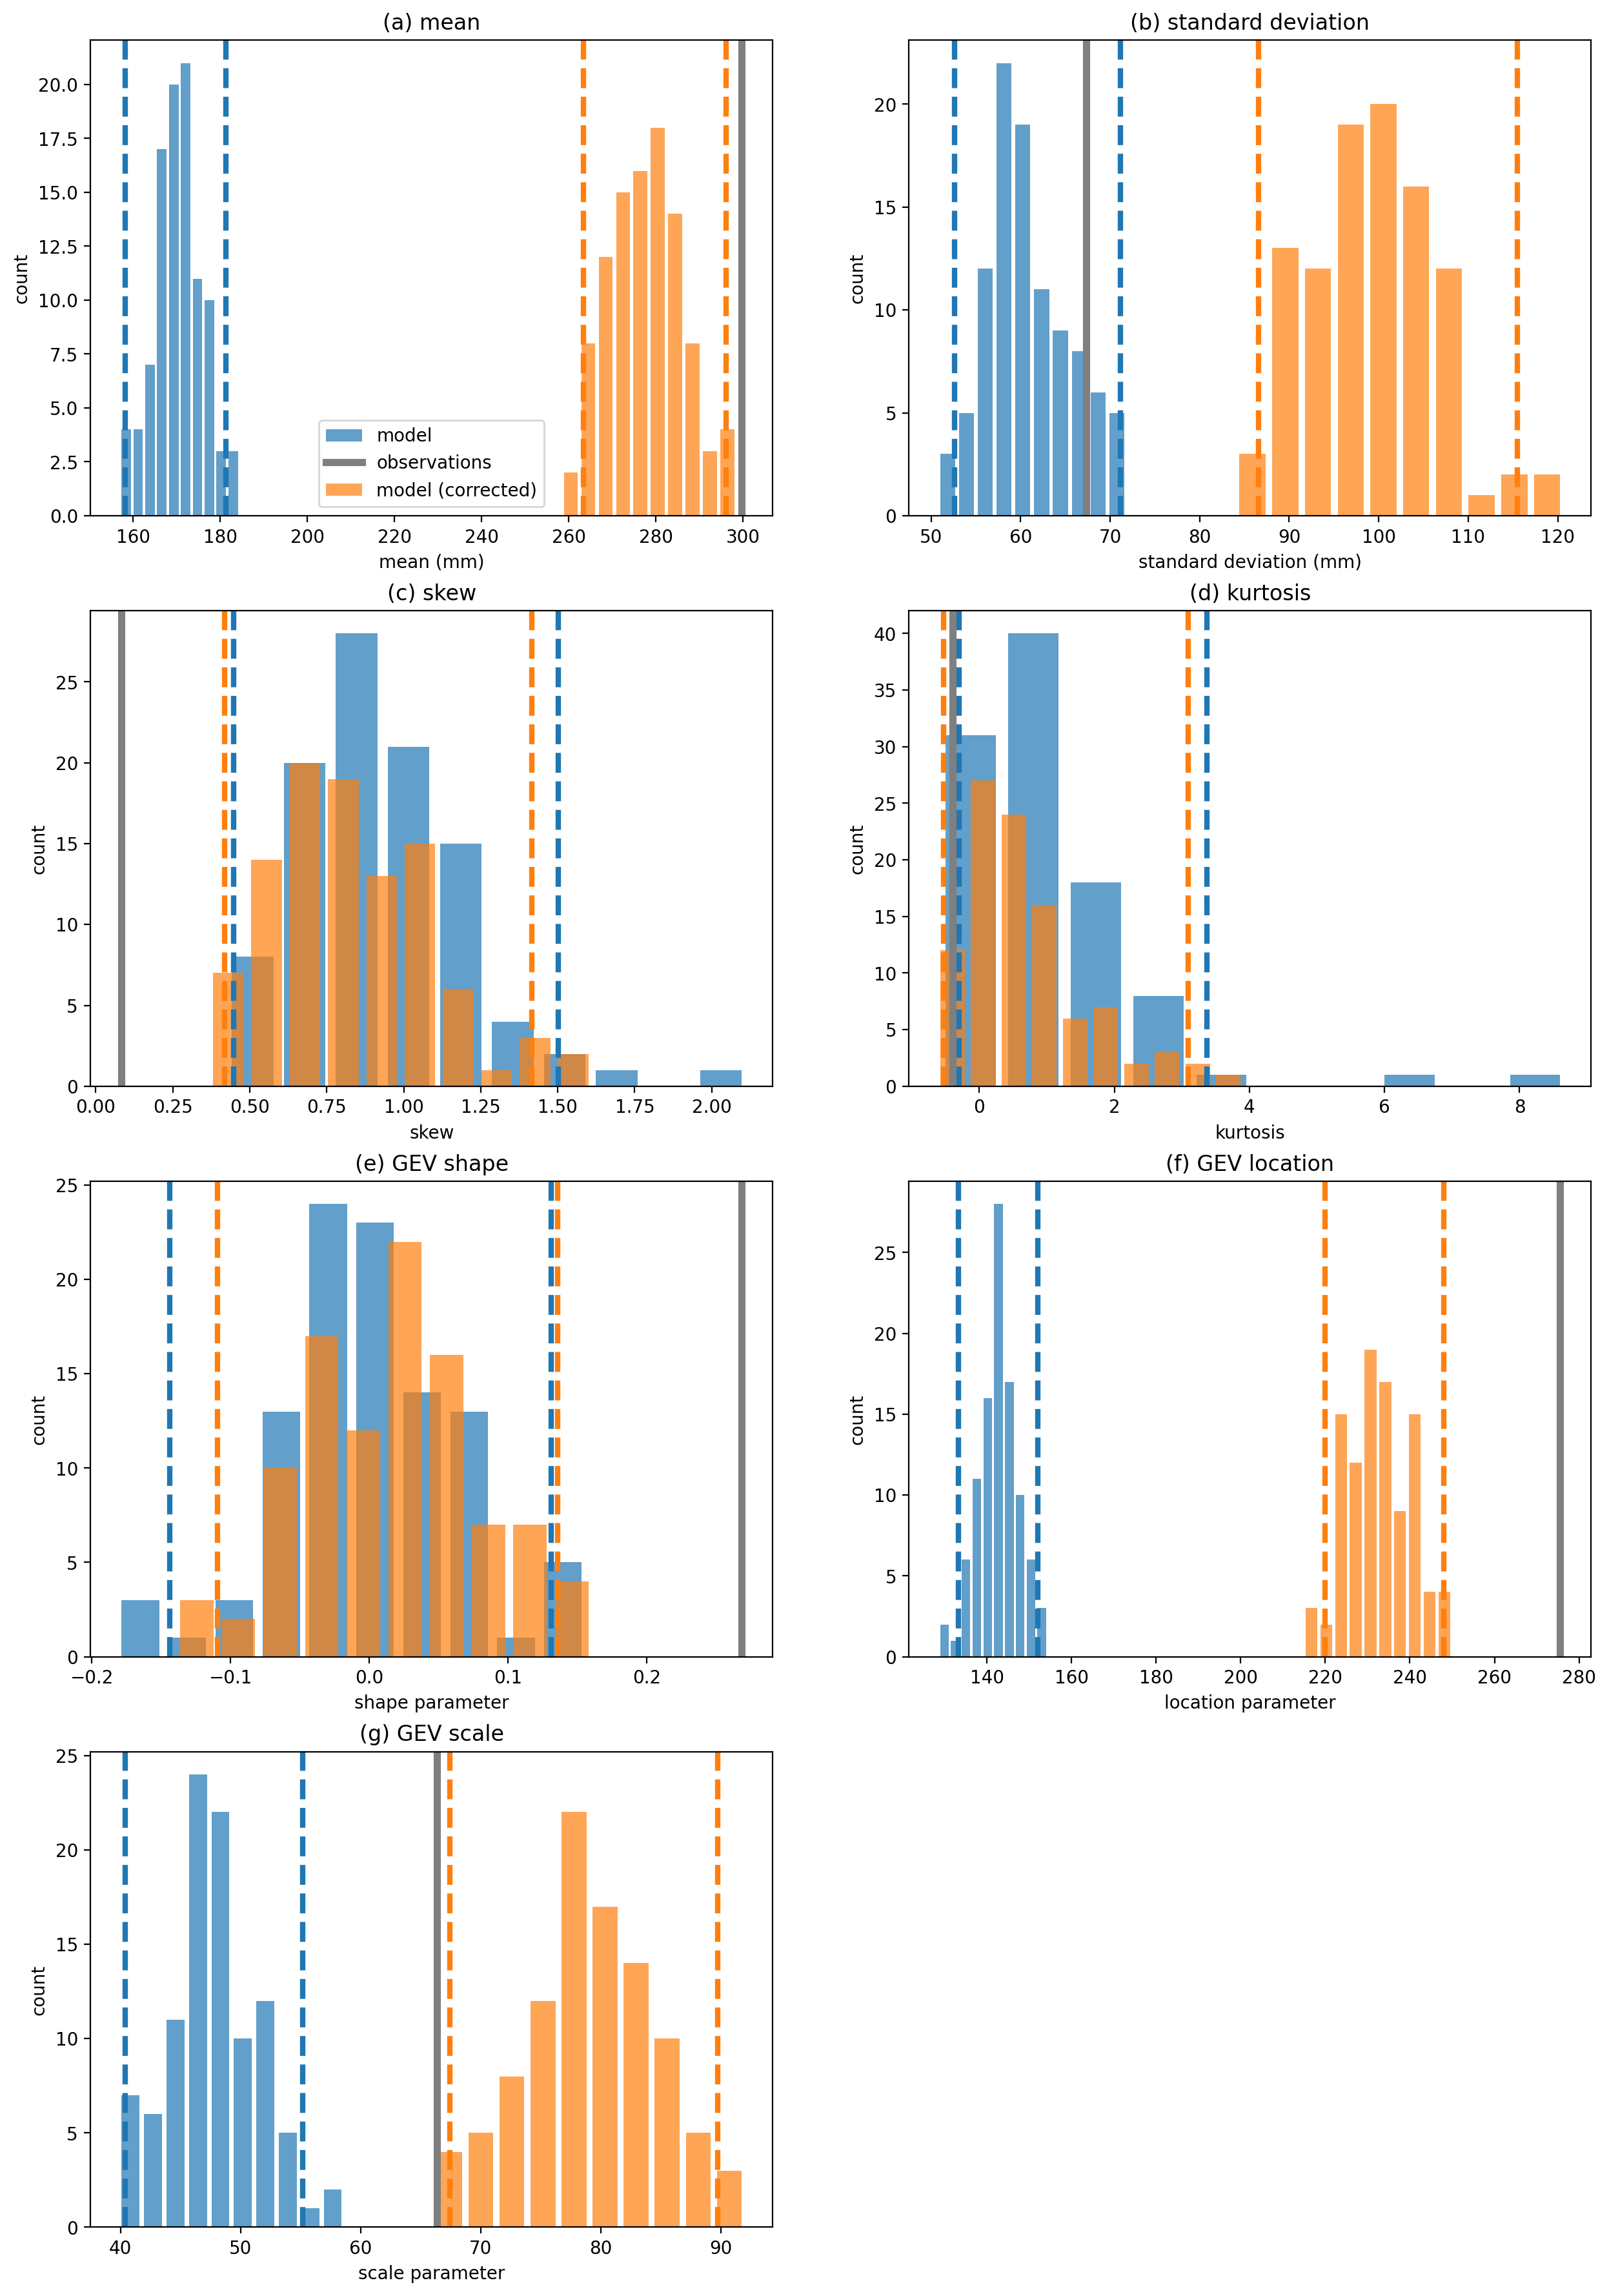

In [52]:
Image(filename=moments_mulc_plot)